# pybacktest tutorial

This tutorial will give you a quick overview of **pybacktest**'s features. To do so, we will backtest classic MA crossover trading strategy:

* go long when short MA crosses above long MA
* go short when short MA crosses below long MA
* entry rules are also exit rules, thus making strategy reversible

Package is available for download at https://github.com/ematvey/pybacktest

In [2]:
from __future__ import print_function

import pybacktest  # obviously, you should install pybacktest before importing it
import pandas as pd

**pybacktest** expects bars to be in `pandas.DataFrame` indexed by datetimestamps, with columns named `O`, `H`, `L`, `C`. Actually, in this version it would only check `O`, and only if trade prices are not explicitly specified.

Lets load data from yahoo using helper.

In [23]:
"""
准备价差数据
"""

names = ['time','lastPrice','volume','openInterest','openInterestYd','openPrice','highPrice','lowPrice','notionalTrade']
rb1910 = pd.read_csv("D:\\tick_mean_reversion\\rb1910.csv", names=names)
rb2001 = pd.read_csv("D:\\tick_mean_reversion\\rb2001.csv", names=names)

# rb1910 = rb1910.set_index('time')
# rb1910.index = pd.DatetimeIndex(rb1910.index)
rb1910['time'] = pd.to_datetime(rb1910['time'])
rb2001['time'] = pd.to_datetime(rb2001['time'])
# rb2001 = rb2001.set_index('time')
# rb2001.index = pd.DatetimeIndex(rb2001.index)

priceSpread = pd.merge(rb1910,rb2001,on='time',how='outer')
priceSpread = priceSpread.set_index('time')
priceSpread['lastPrice_y'].fillna(method='ffill',inplace=True)
priceSpread['rb1910_minus_rb2001'] = priceSpread['lastPrice_x'] - priceSpread['lastPrice_y']
priceSpread = priceSpread['2019-5-6  9:01:00':'2019-5-6  14:59:00']
priceSpread['O']=priceSpread['H']=priceSpread['L']=priceSpread['C']=priceSpread['rb1910_minus_rb2001']
priceSpread.describe()

# priceSpread.to_csv("D:\\tick_mean_reversion\\priceSpread.csv")

,lastPrice_x,volume_x,openInterest_x,openInterestYd_x,openPrice_x,highPrice_x,lowPrice_x,notionalTrade_x,lastPrice_y,volume_y,...,openInterestYd_y,openPrice_y,highPrice_y,lowPrice_y,notionalTrade_y,rb1910_minus_rb2001,O,H,L,C
count,42878.000000,4.287800e+04,4.287800e+04,42878.0,42878.0,42878.000000,42878.000000,4.287800e+04,42878.000000,39525.000000,...,39525.0,39525.0,39525.000000,39525.0,3.952500e+04,42878.000000,42878.000000,42878.000000,42878.000000,42878.000000
mean,3760.003218,1.719675e+06,2.338188e+06,2345822.0,3760.0,3782.990251,3729.438173,6.470754e+10,3485.281520,79152.600076,...,297292.0,3465.0,3499.825579,3446.0,2.760100e+09,274.721699,274.721699,274.721699,274.721699,274.721699
std,11.275089,7.142593e+05,3.042005e+04,0.0,0.0,0.186660,2.632303,2.682406e+10,10.194067,35018.338419,...,0.0,0.0,0.630571,0.0,1.220345e+09,2.965836,2.965836,2.965836,2.965836,2.965836
min,3725.000000,2.450760e+05,2.281840e+06,2345822.0,3760.0,3779.000000,3725.000000,9.204362e+09,3456.000000,8704.000000,...,297292.0,3465.0,3493.000000,3446.0,3.020779e+08,265.000000,265.000000,265.000000,265.000000,265.000000
25%,3752.000000,1.192396e+06,2.309980e+06,2345822.0,3760.0,3783.000000,3725.000000,4.490243e+10,3477.000000,50132.000000,...,297292.0,3465.0,3500.000000,3446.0,1.748470e+09,273.000000,273.000000,273.000000,273.000000,273.000000
50%,3763.000000,1.644374e+06,2.337050e+06,2345822.0,3760.0,3783.000000,3731.000000,6.193155e+10,3489.000000,80346.000000,...,297292.0,3465.0,3500.000000,3446.0,2.804069e+09,275.000000,275.000000,275.000000,275.000000,275.000000
75%,3769.000000,2.379186e+06,2.366706e+06,2345822.0,3760.0,3783.000000,3731.000000,8.946423e+10,3493.000000,110576.000000,...,297292.0,3465.0,3500.000000,3446.0,3.854996e+09,277.000000,277.000000,277.000000,277.000000,277.000000
max,3783.000000,3.020488e+06,2.403682e+06,2345822.0,3760.0,3783.000000,3731.000000,1.135230e+11,3500.000000,138880.000000,...,297292.0,3465.0,3500.000000,3446.0,4.838937e+09,288.000000,288.000000,288.000000,288.000000,288.000000


Now time to define strategy. To do so, all we need to do is to create binary `Series` with signals, and, optionally, trade price `Series` with float elements.

Could this be any simpler?

In [24]:
from statsmodels.tsa.stattools import adfuller as ADF

"""
rb主力和次主力合约的平稳性检验
"""

ret_rb1910 = rb1910['lastPrice']/rb1910['lastPrice'].shift(1).apply(lambda x:np.log(x))
ret_rb2001 = rb2001['lastPrice']/rb2001['lastPrice'].shift(1).apply(lambda x:np.log(x))

tt = ADF((ret_rb1910 - ret_rb2001).dropna()) #单个配对稳定性检验

output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Y-value'])
output['Y-value']['Test Statistic Value'] = tt[0]
output['Y-value']['p-value'] = tt[1]
output['Y-value']['Lags Used'] = tt[2]
output['Y-value']['Number of Observations Used'] = tt[3]
output['Y-value']['Critical Value(1%)'] = tt[4]['1%']
output['Y-value']['Critical Value(5%)'] = tt[4]['5%']
output['Y-value']['Critical Value(10%)'] = tt[4]['10%']
output.columns.name = 'result of rb1910 vs rb2001'
print ("p-value of rb1910 vs rb2001: ",tt[1])
output

ImportError: cannot import name _fblas

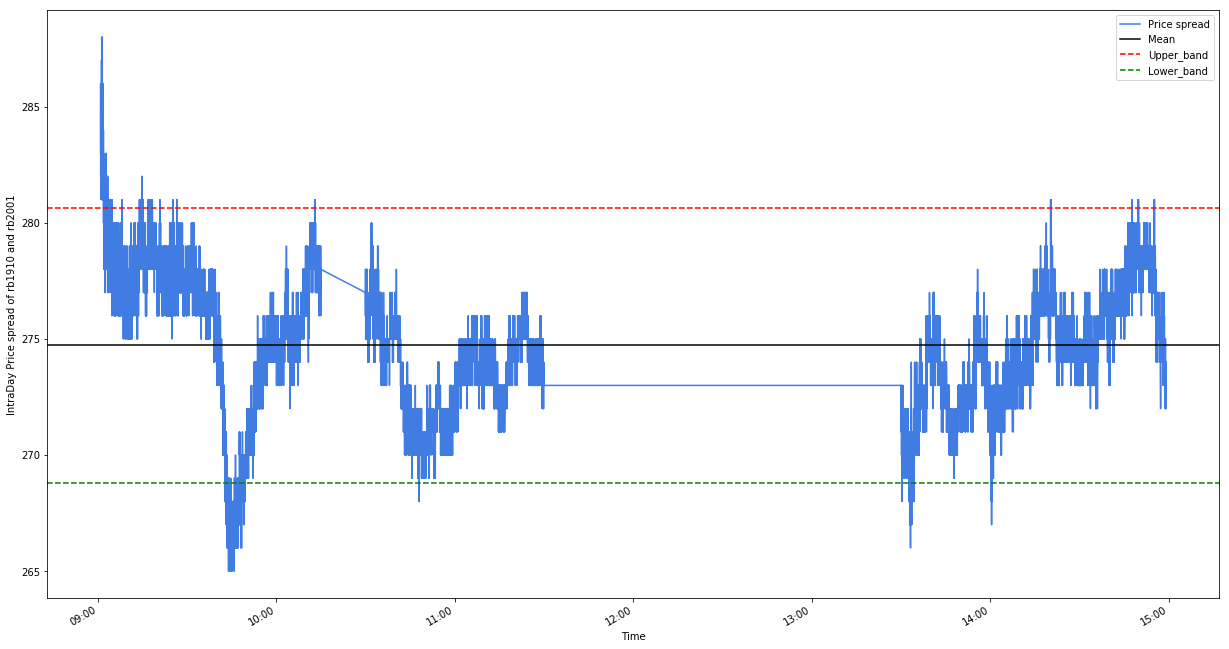

In [25]:
import matplotlib.pylab as plt

"""
画图观察全天价差的波动范围
"""
band_multi = 2 #设定上下轨偏离标准差多少倍

intraDayMean = priceSpread['rb1910_minus_rb2001'].mean()
intraDayStd = priceSpread['rb1910_minus_rb2001'].std()
fig = plt.figure(figsize=(21,12))
priceSpread['rb1910_minus_rb2001'].plot(color='#407CE2')
ax = fig.add_subplot(1,1,1)
plt.axhline(intraDayMean, color="black")
ax.axhline(intraDayMean+band_multi*intraDayStd, color="red", linestyle="--")
ax.axhline(intraDayMean-band_multi*intraDayStd, color="green", linestyle="--")
plt.xlabel("Time"); plt.ylabel("IntraDay Price spread of rb1910 and rb2001")
plt.legend(["Price spread", "Mean","Upper_band","Lower_band"])
plt.show()

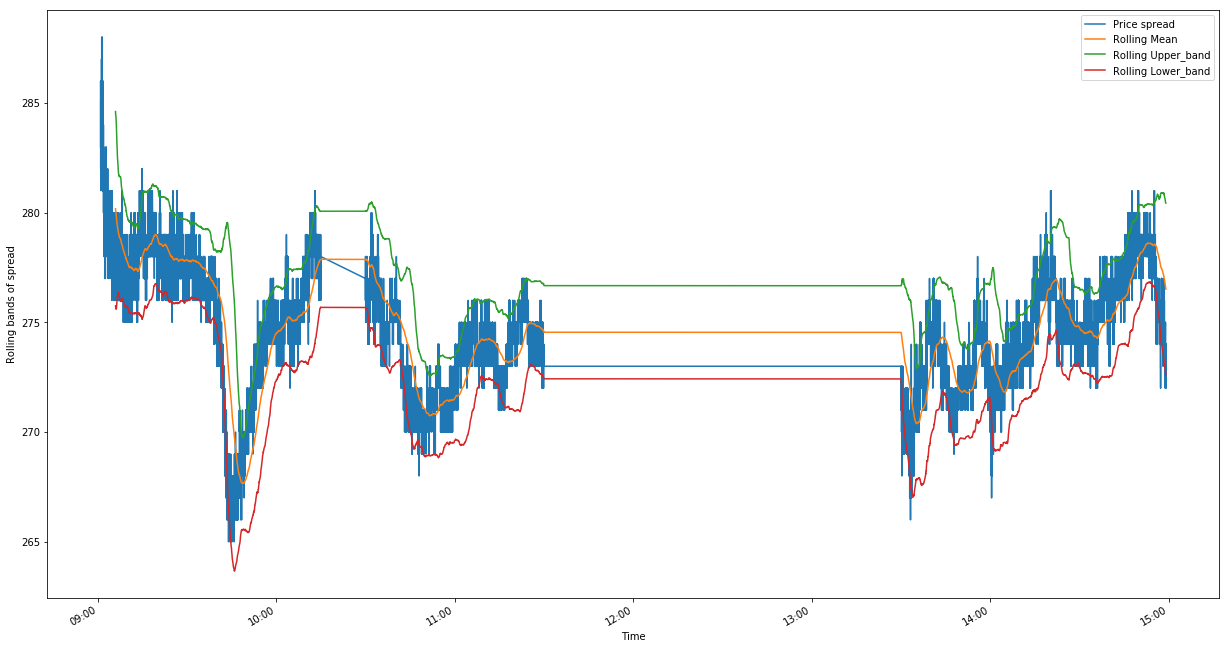

In [26]:
"""
计算滚动波动范围
"""
band_multi = 2 

mean = priceSpread['rb1910_minus_rb2001'].rolling(window=1200).mean()
std = priceSpread['rb1910_minus_rb2001'].rolling(window=1200).std()

pd.concat([priceSpread['rb1910_minus_rb2001'],mean, mean+band_multi*std,mean-band_multi*std], axis=1).plot(figsize=(21,12))
plt.xlabel("Time"); plt.ylabel("Rolling bands of spread")
plt.legend(["Price spread", "Rolling Mean","Rolling Upper_band","Rolling Lower_band"])
plt.show()

In [27]:
window=1200
band_multi = 2 

mean = priceSpread['rb1910_minus_rb2001'].rolling(window=window).mean()
std = priceSpread['rb1910_minus_rb2001'].rolling(window=window).std()

priceSpread['Rolling_Upper_band'] = mean + band_multi * std
priceSpread['Rolling_Lower_band'] = mean - band_multi * std

priceSpread['ShortHolding'] = priceSpread['rb1910_minus_rb2001'] - priceSpread['Rolling_Upper_band']
priceSpread['LongHolding'] = priceSpread['rb1910_minus_rb2001'] - priceSpread['Rolling_Lower_band']

priceSpread.tail(10)
    
buy = cover = (priceSpread['LongHolding'] < 0) & (priceSpread['LongHolding'].shift() > 0)
sell = short = (priceSpread['ShortHolding'] > 0) & (priceSpread['ShortHolding'].shift() < 0)

priceSpread['buy_cover'] = buy
priceSpread['short_sell'] = sell
priceSpread.to_csv("D:\\tick_mean_reversion\\priceSpread.csv")


Time to run backtest. `Backtest` will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling `locals()`), that contains every variable you created up to this point.

In [29]:
bt = pybacktest.Backtest(locals(), 'mean_reversion')

Exception: Bars dataframe was not found in dataobj

`Backtest` runs lazily, i.e. it calculates anything only when you call properties from it. There properties: 

In [5]:
print(list(filter(lambda x: not x.startswith('_'), dir(bt))))
print('\n>  bt.signals\n%s' % bt.signals.tail())
print('\n>  bt.trades\n%s' % bt.trades.tail())
print('\n>  bt.positions\n%s' % bt.positions.tail())
print('\n>  bt.equity\n%s' % bt.equity.tail())
print('\n>  bt.trade_price\n%s' % bt.trade_price.tail())

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy  Cover   Sell  Short
Date                                  
2016-10-05  False  False  False  False
2016-10-06  False  False  False  False
2016-10-07  False  False  False  False
2016-10-10  False  False  False  False
2016-10-11  False  False  False  False

>  bt.trades
            pos       price  vol
Date                            
2012-01-24  1.0  118.699844  2.0
2015-09-04 -1.0  187.808625 -2.0
2015-12-10  1.0  201.090047  2.0
2016-01-19 -1.0  187.062636 -2.0
2016-04-21  1.0  207.982340  2.0

>  bt.positions
Date
2012-01-23    1.0
2015-09-03   -1.0
2015-12-09    1.0
2016-01-15   -1.0
2016-04-20    1.0
dtype: float64

>  bt.equity
Date
2012-01-24   -14.184135
2015-09-04    69.108781
2015-12-10   -13.281422
2016-01-19   -14.027411
2016-04

Some of popular performance statistics could be requested by calling `summary` method of `Backtest`.

In [6]:
bt.summary()

----------------------------------------------
|  Backtest(ma_cross, 2016-12-10 19:14 MSK)  |
('----------------------------------------------', '\n')
backtest:
  days: 7902
  from: '1994-09-02 00:00:00'
  to: '2016-04-21 00:00:00'
  trades: 21
performance:
  PF: 2.7793
  RF: 3.4981
  averages:
    gain: 23.9572
    loss: -9.4819
    trade: 8.0338
  payoff: 2.5266
  profit: 168.7103
  winrate: 0.5238
risk/return profile:
  MPI: 0.5665
  UPI: 0.5665
  WCDD (monte-carlo 0.99 quantile): 69.1196
  maxdd: 48.2285
  sharpe: 0.3593
  sortino: 1.1669

----------------------------------------------


Now lets look at equity curve.

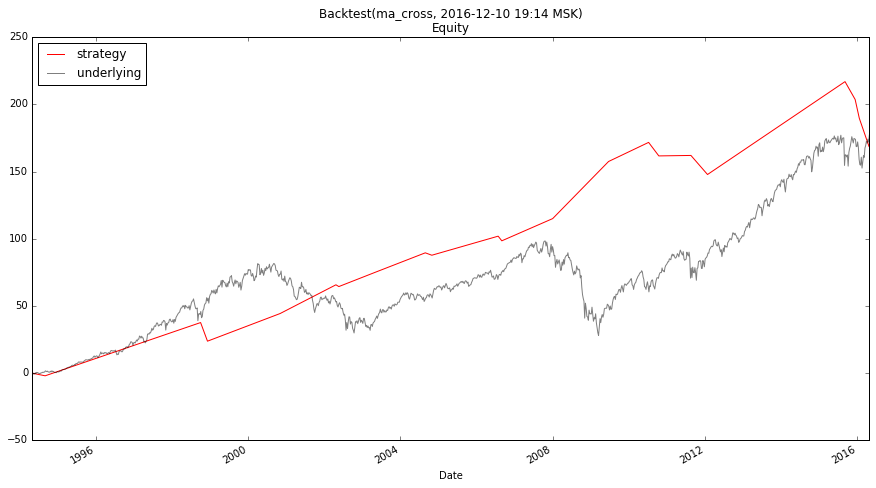

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

bt.plot_equity()

But what if you want to see what exactly was going on during backtest run? Well, `Backtest` can plot trades as they happened for you. Legend is hidden by default to save space.

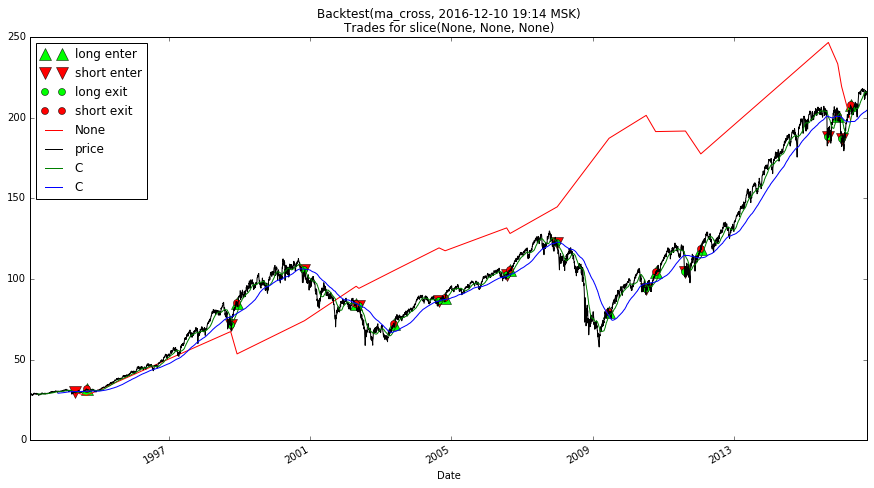

In [8]:
bt.plot_trades()
ohlc.C.rolling(short_ma).mean().plot(c='green')
ohlc.C.rolling(long_ma).mean().plot(c='blue')
plt.legend(loc='upper left')
pass

Can you see anything there? I can't. That's why we have special a very special `trdplot` property, which allowes you specify what period do you want to plot using standard `pandas` indexing mechanisms. Same trick could be done with equity curve using `eqplot` property.

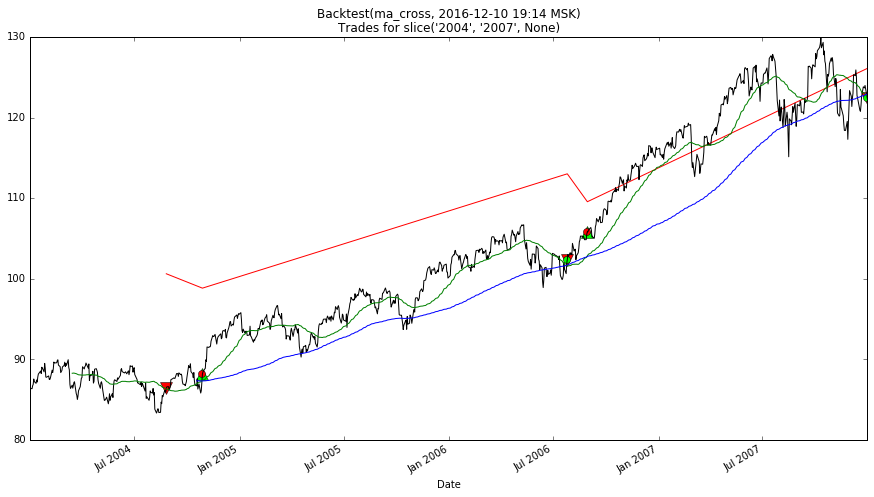

In [9]:
bt.trdplot['2004':'2007']
ohlc.C['2004':'2007'].rolling(short_ma).mean().plot(c='green')
ohlc.C['2004':'2007'].rolling(long_ma).mean().plot(c='blue')
pass

That's the most of it.